# CycleGAN

## Set up the input pipeline

In [ ]:
# !apt-get update && apt-get install libgl1

In [39]:
import tensorflow as tf
import numpy as np

In [40]:
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [41]:
# train_A = tf.data.Dataset.list_files(str('../Dataset/Rebuild/MRI/*'), shuffle=False)
# train_B = tf.data.Dataset.list_files(str('../Dataset/Rebuild/CT/*'), shuffle=False)
test_A  = tf.data.Dataset.list_files(str('dataset/MRI_test/*'), shuffle=False)
test_B  = tf.data.Dataset.list_files(str('dataset/CT_test/*'), shuffle=False)

train_A = tf.data.Dataset.list_files(str('dataset/MRI_train/*'), shuffle=False)
train_B = tf.data.Dataset.list_files(str('dataset/CT_train/*'), shuffle=False)


In [42]:
# dataset = load_image_dataset('dataset/')


def load_images(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    label = tf.strings.split(path, os.path.sep)[-2]
    return image, label

train_mri = train_A.map(load_images)
train_ct = train_B.map(load_images)
test_mri  = test_A.map(load_images)
test_ct  = test_B.map(load_images)

In [43]:
BUFFER_SIZE = 1000
BATCH_SIZE  = 15
IMG_WIDTH   = 256
IMG_HEIGHT  = 256
CHANNELS    = 1

In [44]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, CHANNELS])

  return cropped_image

In [45]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [46]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [47]:
def preprocess_image_train(image, label):
  # image = random_jitter(image)
  image = tf.image.resize(image, [256, 256],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = tf.image.rgb_to_grayscale(image)
  image = normalize(image)
  return image

In [48]:
def preprocess_image_test(image, label):
  image = tf.image.resize(image, [256, 256],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = normalize(image)
  return image

In [49]:
train_mri = train_mri.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_ct = train_ct.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_mri = test_mri.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_ct = test_ct.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [50]:
sample_MRI = next(iter(train_mri))
sample_CT = next(iter(train_ct))

2024-10-16 09:07:12.522588: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-16 09:07:12.809480: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


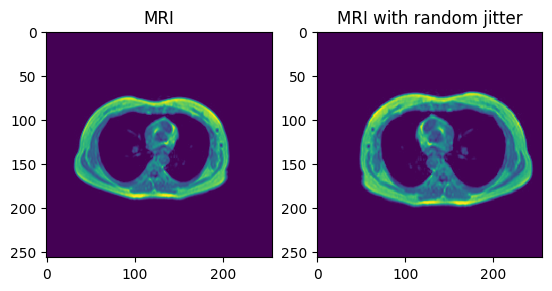

In [51]:
plt.subplot(121)
plt.title('MRI')
plt.imshow(sample_MRI[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('MRI with random jitter')
plt.imshow(random_jitter(sample_MRI[0]) * 0.5 + 0.5)

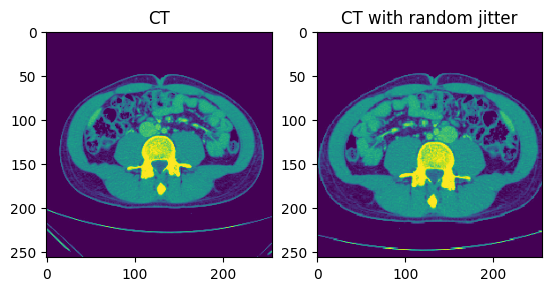

In [52]:
plt.subplot(121)
plt.title('CT')
plt.imshow(sample_CT[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('CT with random jitter')
plt.imshow(random_jitter(sample_CT[0]) * 0.5 + 0.5)

## Import and reuse the Pix2Pix models

In [53]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
    
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

## Shape

Output shape = (Input - kernel size +1) / stride

(256 -4 + 1) / 2 = 128
 

In [54]:
class InstanceNormalization(tf.keras.layers.Layer):

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [55]:
norm_type='batchnorm'
n = 1
down_stack_origin = [
    downsample(64 * n, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
    downsample(128* n, 4, norm_type),  # (bs, 64, 64, 128)
    downsample(256* n, 4, norm_type),  # (bs, 32, 32, 256)
    downsample(512* n, 4, norm_type),  # (bs, 16, 16, 512)
    downsample(512* n, 4, norm_type),  # (bs, 8, 8, 512)
    downsample(512* n, 4, norm_type),  # (bs, 4, 4, 512)
    downsample(512* n, 4, norm_type),  # (bs, 2, 2, 512)
    downsample(512* n, 4, norm_type),  # (bs, 1, 1, 512)
]
up_stack_origin = [
    upsample(512* n, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
    upsample(512* n, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
    upsample(512* n, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
    upsample(512* n, 4, norm_type),  # (bs, 16, 16, 1024)
    upsample(256* n, 4, norm_type),  # (bs, 32, 32, 512)
    upsample(128* n, 4, norm_type),  # (bs, 64, 64, 256)
    upsample(64* n, 3, norm_type),  # (bs, 128, 128, 128)
]

down_stack_light = [
    downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
    downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
    downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
    downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
    downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
]

up_stack_light = [
    upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
    upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
    upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
    upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
]

down_stack_test = [
    downsample(64  , 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
    downsample(128 , 4, norm_type),  # (bs, 64, 64, 128)
    downsample(256 , 4, norm_type),  # (bs, 32, 32, 256)
    downsample(512 , 4, norm_type),  # (bs, 16, 16, 512)
    downsample(512 , 4, norm_type),  # (bs, 8, 8, 512)
    downsample(512 , 4, norm_type),  # (bs, 4, 4, 512)
    downsample(1024 , 4, norm_type),  # (bs, 2, 2, 512)
    downsample(1024 , 4, norm_type),  # (bs, 1, 1, 512)
]
up_stack_test = [
    upsample(1024 , 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
    upsample(1024 , 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
    upsample(512 , 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
    upsample(512 , 4, norm_type),  # (bs, 16, 16, 1024)
    upsample(256 , 4, norm_type),  # (bs, 32, 32, 512)
    upsample(128 , 4, norm_type),  # (bs, 64, 64, 256)
    upsample(64  , 4, norm_type),  # (bs, 128, 128, 128)
]

In [56]:
def unet_generator(output_channels, norm_type='batchnorm'):

  down_stack = down_stack_test

  up_stack = up_stack_test


  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation=None)  # WGAN Remove Activation Last Layer

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, CHANNELS])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [57]:
def discriminator(norm_type='batchnorm', target=True):

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, CHANNELS], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, CHANNELS], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer, activation=None)(zero_pad2)  # Remove last layer activation

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

In [58]:
OUTPUT_CHANNELS = CHANNELS

# generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

In [59]:
sample_MRI.shape

TensorShape([15, 256, 256, 1])

In [60]:
to_CT = generator_g(sample_MRI)
to_MRI = generator_f(sample_CT)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_MRI, to_CT, sample_CT, to_MRI]
title = ['MRI', 'To CT', 'CT', 'To MRI']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [61]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real CT?')
plt.imshow(discriminator_y(sample_CT)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real MRI?')
plt.imshow(discriminator_x(sample_MRI)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In [62]:
LAMBDA = 0.5

In [63]:
loss_obj = tf.keras.losses.MeanSquaredError()
# loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [64]:
class feature_mapping(tf.keras.Model):
  def __init__(self):
    super(feature_mapping, self).__init__()
    self.conv1      = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
    self.pool1       = tf.keras.layers.MaxPooling2D((2, 2))
    self.conv2      = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
    self.pool2       = tf.keras.layers.MaxPooling2D((2, 2))
    self.conv3      = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
    self.pool3       = tf.keras.layers.MaxPooling2D((2, 2))
    self.conv4      = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
    self.pool4       = tf.keras.layers.MaxPooling2D((2, 2))
    self.Flat       = tf.keras.layers.Flatten()
    self.dense      = tf.keras.layers.Dense(128, activation='relu')

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.pool3(x)
    x = self.conv4(x)
    x = self.pool4(x)
    x = self.Flat(x)
    x = self.dense(x)
    return x

extractor = feature_mapping()

def feature_matching_loss(generated, real):
  if(generated.shape != real.shape):
    tf.reshape(real, generated.shape)
  real_features = extractor(real)
  generated_features = extractor(generated)
  # print(real_features.shape)
  # print(generated_features.shape)
  return tf.reduce_mean(tf.square(real_features - generated_features))


In [65]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  # matching_loss = feature_matching_loss(generated, real)

  total_disc_loss = real_loss + generated_loss #+ matching_loss

  return total_disc_loss * 0.5 

In [66]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [67]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [68]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [69]:
def clip_gradient(gradient):
  return tf.clip_by_value(gradient, -1.0, 1.0)

Initialize the optimizers for all the generators and the discriminators.

In [70]:
generator_g_optimizer = tf.keras.optimizers.RMSprop(learning_rate= 2e-2)
generator_f_optimizer = tf.keras.optimizers.RMSprop(learning_rate= 2e-2)

discriminator_x_optimizer = tf.keras.optimizers.RMSprop(learning_rate= 2e-4)
discriminator_y_optimizer = tf.keras.optimizers.RMSprop(learning_rate= 2e-4)

# generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-6, beta_1=0.5)
# discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-6, beta_1=0.5)

## Checkpoints

In [71]:
checkpoint_path = "./checkpoints/train" 

In [72]:
# Save Checkpoints
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=20)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training


In [73]:
def generate_images(model, test_input, filename):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
  plt.savefig(f'{filename}.png', bbox_inches='tight')
  plt.show()

In [74]:
sess = tf.compat.v1.Session()

In [75]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y   = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x  = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    #matching loss

    matching_loss_x = feature_matching_loss(cycled_x, real_x)
    matching_loss_y = feature_matching_loss(cycled_y, real_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y) + matching_loss_x
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x) + matching_loss_y
    
    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  discriminator_x_gradients = [clip_gradient(grad) for grad in discriminator_x_gradients]
  discriminator_y_gradients = [clip_gradient(grad) for grad in discriminator_y_gradients]

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  
  return gen_g_loss, gen_f_loss , disc_x_loss, disc_y_loss ,identity_loss(real_y, same_y), identity_loss(real_x, same_x), matching_loss_x, matching_loss_y

In [76]:
EPOCHS = 1
Loss = []

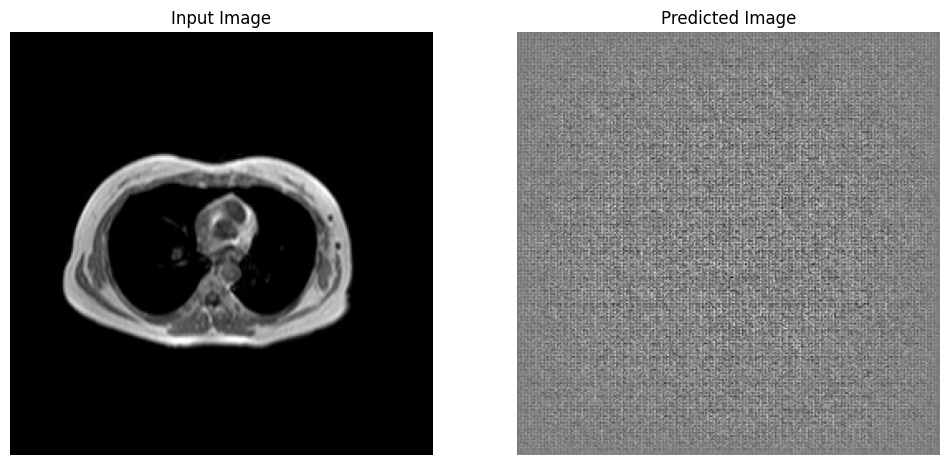

In [77]:
generate_images(generator_g, sample_MRI, "First Try")

In [78]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_mri, train_ct)):
    gen_g_loss, gen_f_loss , disc_x_loss, disc_y_loss ,identity_loss_y, identity_loss_x, matching_loss_x, matching_loss_y = train_step(image_x, image_y)
    Loss.append([gen_g_loss.numpy(), gen_f_loss.numpy(), disc_x_loss.numpy(), disc_y_loss.numpy(), identity_loss_y.numpy(), identity_loss_x.numpy(), matching_loss_x.numpy(), matching_loss_y.numpy()])    

    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_MRI) so that the progress of the model
  # is clearly visible.
  filename = f"Epoch {epoch}"
  generate_images(generator_g, sample_MRI, filename)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

..

In [41]:
loss_array = np.array(Loss)
np.save('loss.npy', loss_array)

In [42]:
loss1 = loss_array[:, 0]  # Assuming loss1 is the first column
loss2 = loss_array[:, 1]
loss3 = loss_array[:, 2]
loss4 = loss_array[:, 3]
loss5 = loss_array[:, 4]
loss6 = loss_array[:, 5]
loss7 = loss_array[:, 6]
loss8 = loss_array[:, 7]

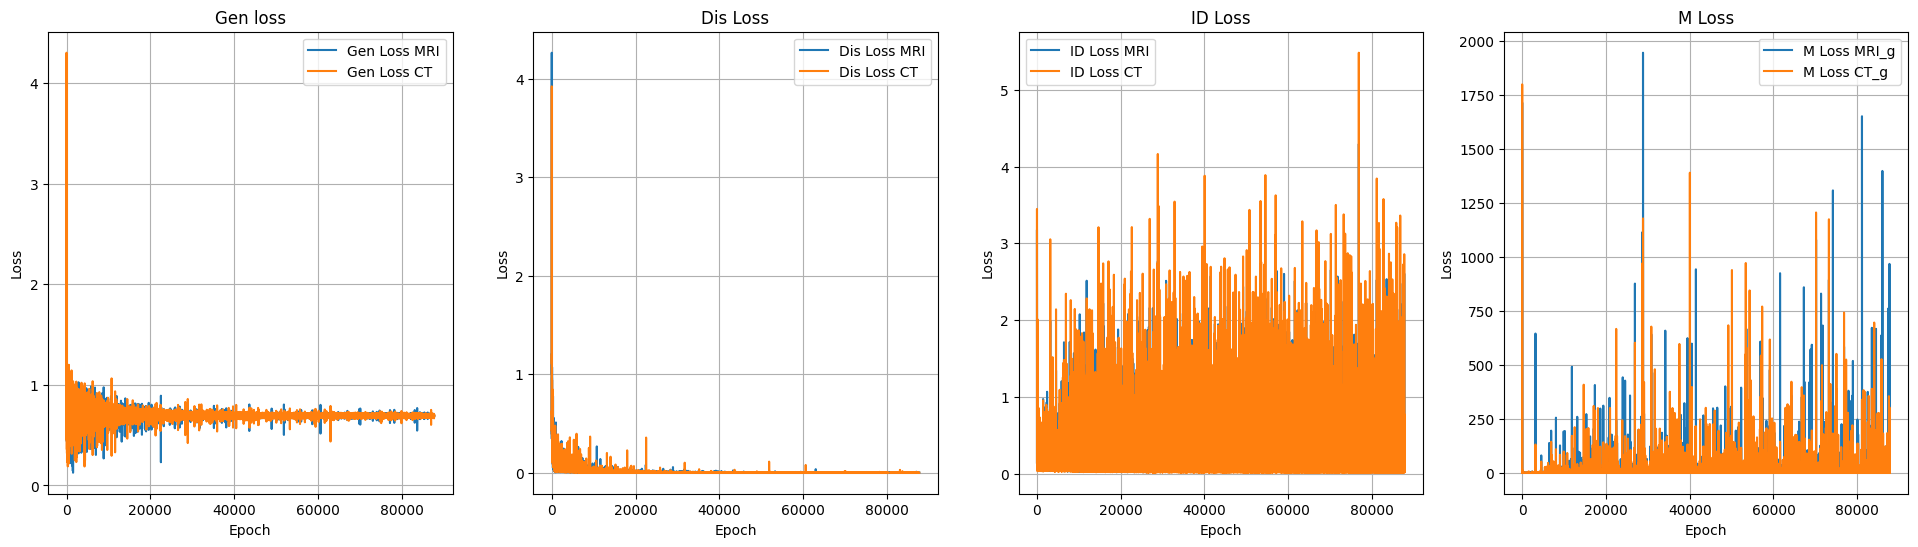

In [47]:
epochs = range(len(loss1))

plt.figure(figsize=(24, 6))
plt.subplot(1,4,1)
plt.plot(epochs, loss1, label='Gen Loss MRI')
plt.plot(epochs, loss2, label='Gen Loss CT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Gen loss")
plt.legend()
plt.grid(True)
plt.subplot(1,4,2)
plt.plot(epochs, loss3, label='Dis Loss MRI')
plt.plot(epochs, loss4, label='Dis Loss CT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Dis Loss')
plt.legend()
plt.grid(True)
plt.subplot(1,4,3)
plt.plot(epochs, loss5, label='ID Loss MRI')
plt.plot(epochs, loss6, label='ID Loss CT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ID Loss')
plt.legend()
plt.grid(True)
plt.subplot(1,4,4)
plt.plot(epochs, loss7, label='M Loss MRI_g')
plt.plot(epochs, loss8, label='M Loss CT_g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('M Loss')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
loss1 = np.log1p(loss_array[:, 0])  # Assuming loss1 is the first column
loss2 = np.log1p(loss_array[:, 1])
loss3 = np.log1p(loss_array[:, 2])
loss4 = np.log1p(loss_array[:, 3])

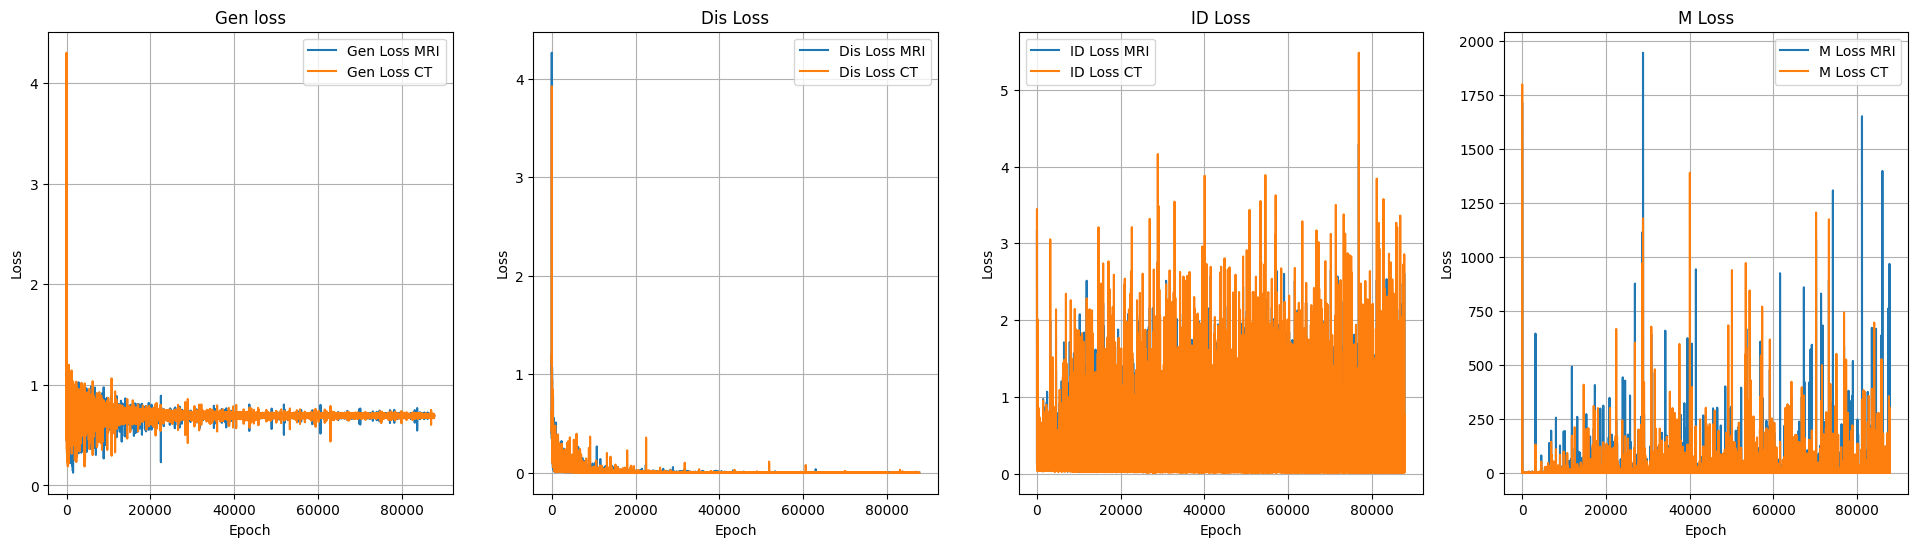

In [45]:
epochs = range(len(loss1))

plt.figure(figsize=(24, 6))
plt.subplot(1,4,1)
plt.plot(epochs, loss1, label='Gen Loss MRI')
plt.plot(epochs, loss2, label='Gen Loss CT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Gen loss")
plt.legend()
plt.grid(True)
plt.subplot(1,4,2)
plt.plot(epochs, loss3, label='Dis Loss MRI')
plt.plot(epochs, loss4, label='Dis Loss CT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Dis Loss')
plt.legend()
plt.grid(True)
plt.subplot(1,4,3)
plt.plot(epochs, loss5, label='ID Loss MRI')
plt.plot(epochs, loss6, label='ID Loss CT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ID Loss')
plt.legend()
plt.grid(True)
plt.subplot(1,4,4)
plt.plot(epochs, loss7, label='M Loss MRI')
plt.plot(epochs, loss8, label='M Loss CT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('M Loss')
plt.legend()
plt.grid(True)
plt.show()

## Generate using test dataset

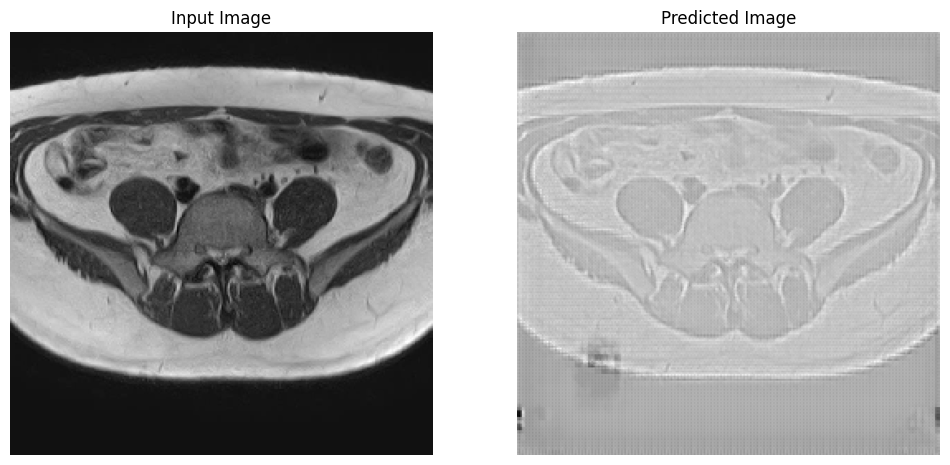

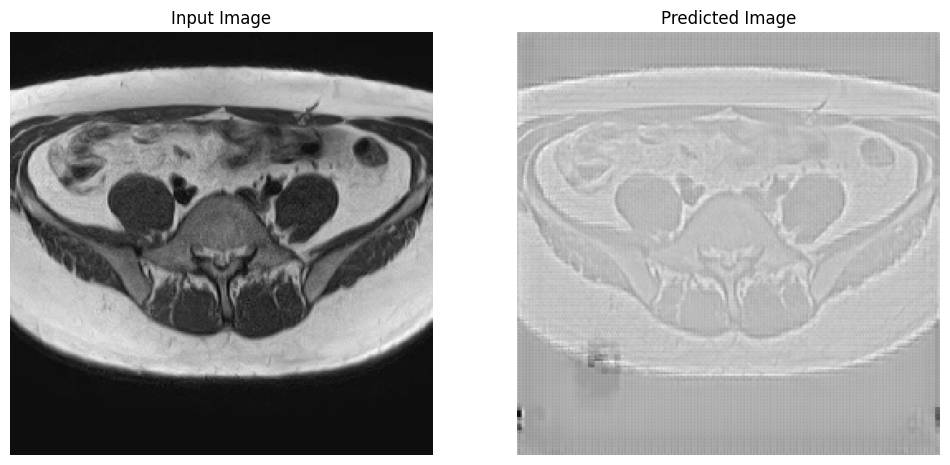

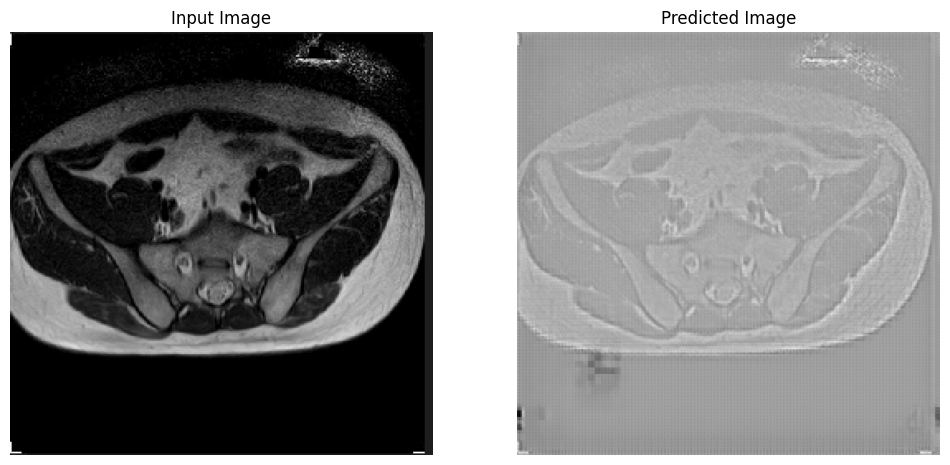

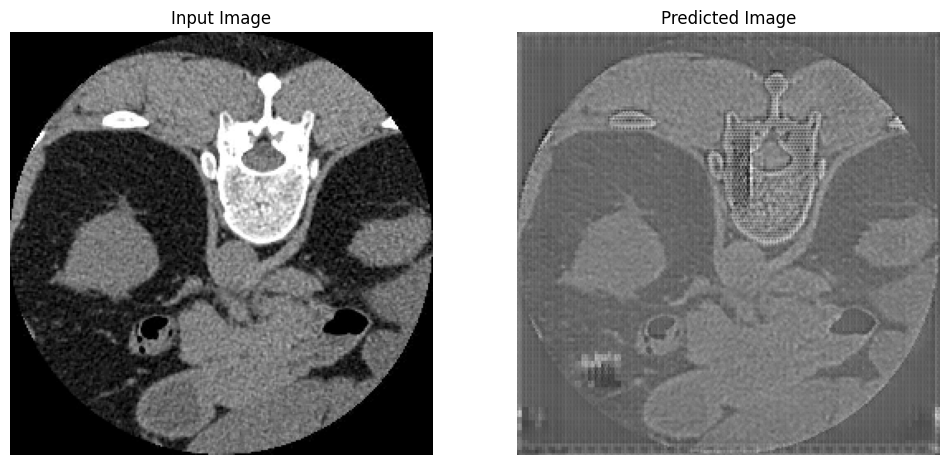

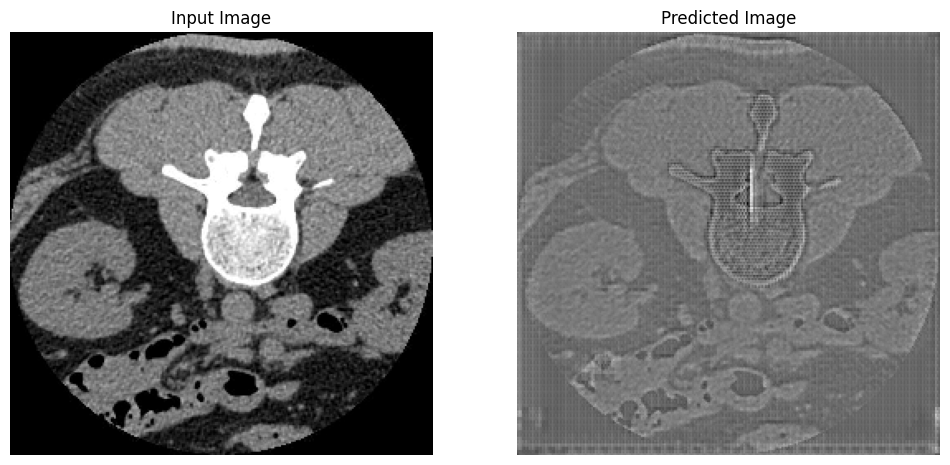

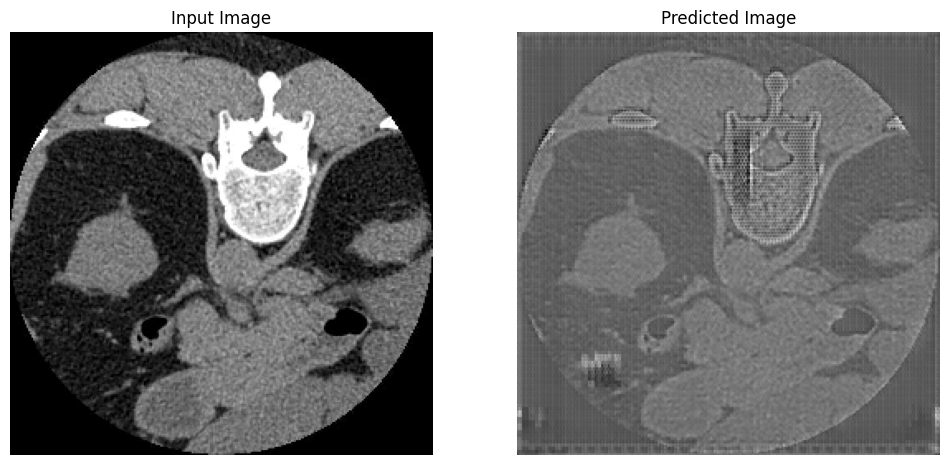

In [48]:
# Run the trained model on the test dataset
for inp in train_mri.take(5):
  generate_images(generator_g, inp, "test")
for inp in train_ct.take(5):
  generate_images(generator_f, inp, "test")